In [1]:
import numpy as np
from scipy.io import loadmat
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re

import warnings
warnings.filterwarnings('ignore')

# SPES Exploration
This is a Single Pulse exploration notebook. The goal here is interact with basic I/O for SPES data and prototype some methods for CRP parameterization 

In [169]:
# # Basic viz
# DATA_FOLDER = '/mnt/ernie_main/000_Data/SPES/data/preprocessed/'
# files = []
# spes_dfs = []
# for pulse in range(1,11):
#     file = f'Epat26/Epat26_CCEP_single_pulses/Epat26_LAC3-LAC4_5mA_pulse_{pulse}.mat'
#     files.append(file)
#     spes_trial = loadmat(os.path.join(DATA_FOLDER, file))
#     fs = spes_trial['fs'][0][0]
#     full_train = spes_trial["pulse"]
#     labels  = [l[0] for l in spes_trial['labels'][0]]
#     df = construct_spes_df(full_train, labels,fs)
#     df['trial'] = pulse
#     spes_dfs.append(df)
# stim_contact = get_stim(files[0])
# spes_dfs = pd.concat(spes_dfs)

<Axes: >

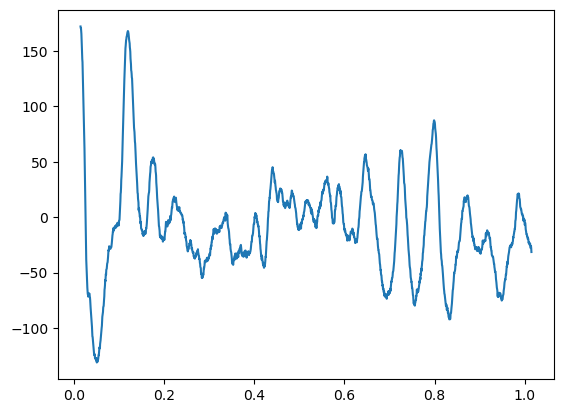

 Miller data is sampled at 2048 Hz


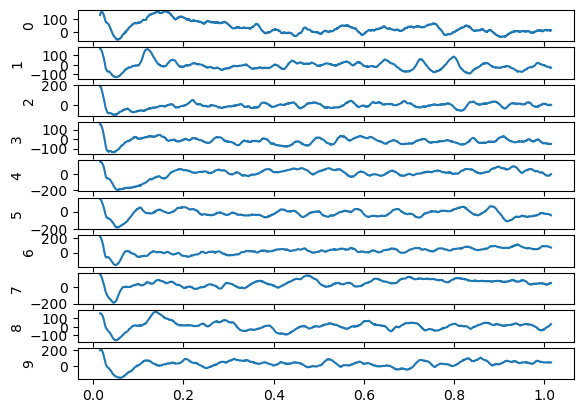

In [22]:
miller_data = loadmat("../../crp_scripts/sampledata/Fig3_sampledata.mat")
full_train = miller_data['data']
t_vec = miller_data['t']
tpts = np.where(np.abs(t_vec[0,:] -.015 - 0.5) <= 0.5) # equivalent to 0.15 < t_vec < 1
t_vec = t_vec[0,tpts]
full_train = full_train[tpts]
miller_df = pd.DataFrame(data=full_train,index=t_vec[0,:], columns=np.arange(10))
plot_channels(miller_df,np.arange(10))
fs = 1/np.mean(np.diff(t_vec))
print(f" Miller data is sampled at {int(fs)} Hz")


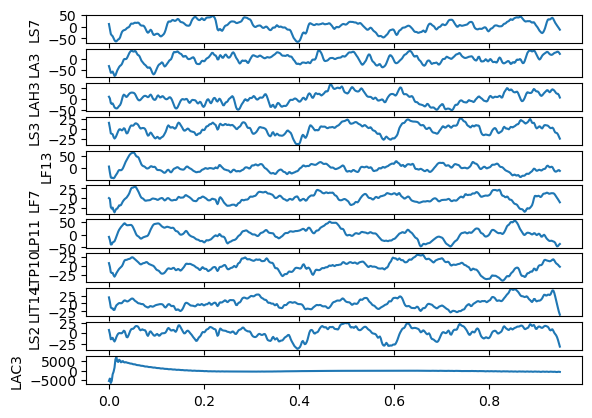

In [207]:
# spes_df = spes_dfs[spes_dfs.trial==5]
# rind10 = np.random.random_integers(0,len(labels)-1,10)
# chs_to_plot = list(spes_df.columns[rind10])
# if stim_contact[0] not in chs_to_plot:
#     chs_to_plot.append(stim_contact[0])
# plot_channels(spes_df, chs_to_plot)


In [23]:
t_ix = lambda t: round(t*fs)

In [24]:
spes_df.columns[0:-1]
region_df = spes_dfs.pivot(columns='trial',values=vals)
set([a for a,_ in region_df.columns])

NameError: name 'spes_df' is not defined

<Axes: >

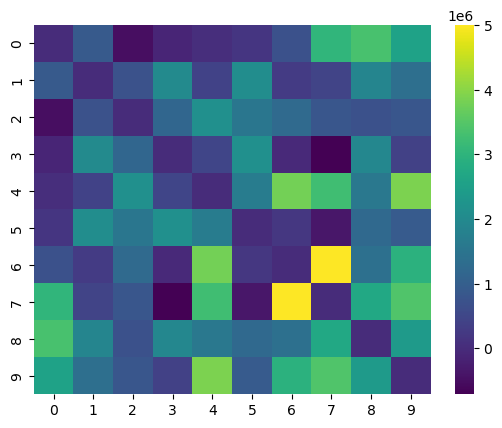

In [25]:
#TODO need to incorporate artifact removal and then work on cross projection. 
#For now, it would be interesting to get global cross projection

k = 10
resp_region = 'LAH3'
resp_areas = miller_df.values #region_df[resp_region].values
#resp_areas = resp_areas[t_ix(.1):t_ix(.15)]
full_crossproj = resp_areas.T@resp_areas
full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(k)
df_full_crossproj = pd.DataFrame(data=full_crossproj)
sns.heatmap(df_full_crossproj, cmap="viridis")


In [66]:
s =0 #paper assumes clean stim t_ix(.025)
cross_dfs = []
import pdb

#TODO consider adding area relationships
for e in np.arange(10,np.max(full_train.shape),5 ):
    #e = t_ix(t)
    win_len = e/fs
    V_raw = resp_areas[0:e,:]
    # norm length of time
    norm = np.linalg.norm(V_raw, axis=0)
    V_norm =V_raw/ norm[None,:]

    full_crossproj = V_norm.T@V_raw
    full_crossproj = full_crossproj - np.diag(full_crossproj)*np.identity(k)
    full_crossproj /= np.sqrt(fs)
    #pdb.set_trace()
    df = pd.DataFrame(data=full_crossproj.flatten(), columns=['cross_proj'])
    df['win_size'] = win_len
    cross_dfs.append(df)
cross_proj_df = pd.concat(cross_dfs)



In [67]:
m =cross_proj_df.groupby(by='win_size').mean()
max_val = np.max(m['cross_proj'].values)

tr_win = m[m.cross_proj == max_val].index[0] #win_size will be index here
#TODO change back
tr_ind = t_ix(tr_win) #t_ix(tr_win+.15)
print(f"tr_max: {tr_win+.015} at index: {tr_ind}")

tr_max: 0.07603515625 at index: 125


<Axes: xlabel='win_size', ylabel='cross_proj'>

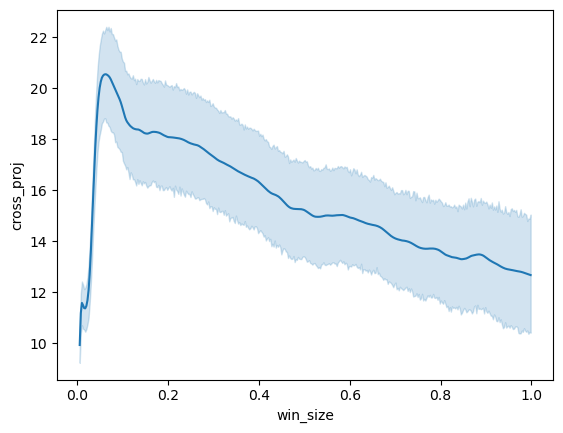

In [68]:
sns.lineplot(data=cross_proj_df, x="win_size", y="cross_proj")

In [83]:
V_tr = resp_areas[s:tr_ind]
eigenV = lin_PCA(V_tr)

In [84]:
n_t, k = eigenV.shape

In [207]:
crp = -1*eigenV[:,0] #get top PC for crp
full_trial = V_tr
#norm = np.linalg.norm(full_trial, axis=1)
#full_norm =full_trial/ norm[:,None]
#alphas = crp.T@V_tr  #full_norm
spes_trial = pd.DataFrame(data=V_tr, columns=[f'raw_{i}'for i in range(k)])
t = np.linspace(0,tr_win ,n_t)
spes_trial['time'] = t


In [208]:
alphas = crp.T@V_tr #full_norm
proj = crp.reshape(n_t,1)@alphas.reshape(1,k)
ep = V_tr - proj #full_norm - proj
df1 = pd.DataFrame(data=proj,columns=[f'proj_{i}'for i in range(k)])
df1['time'] = t

df2 = pd.DataFrame(data=ep, columns=[f'epsilon_{i}' for i in range(k)])
df2['time'] = t


trial_reparam_df = df1.merge(df2,on='time')
trial_reparam_df = trial_reparam_df.merge(spes_trial, on='time')
trial_reparam_df['crp'] = crp

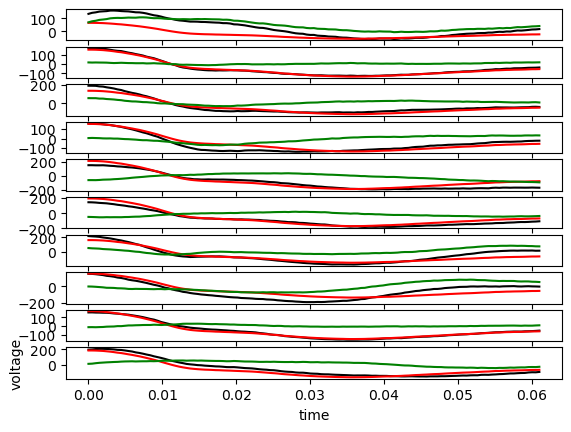

In [209]:
#plot_reparam(trial_reparam_df,10)

my_colors = ['k','r','g']

fig, axes = plt.subplots(nrows=k, ncols=1,sharex=True)
for i in range(k):
    axis=axes[i]
    cols = [f'raw_{i}', f'proj_{i}', f'epsilon_{i}','time']
    ax = trial_reparam_df[cols].plot(kind='line',x='time',color=my_colors, ax=axis,legend=False)
    plt.ylabel('voltage')
    plt.xlabel("time")
    ax.get_legend()





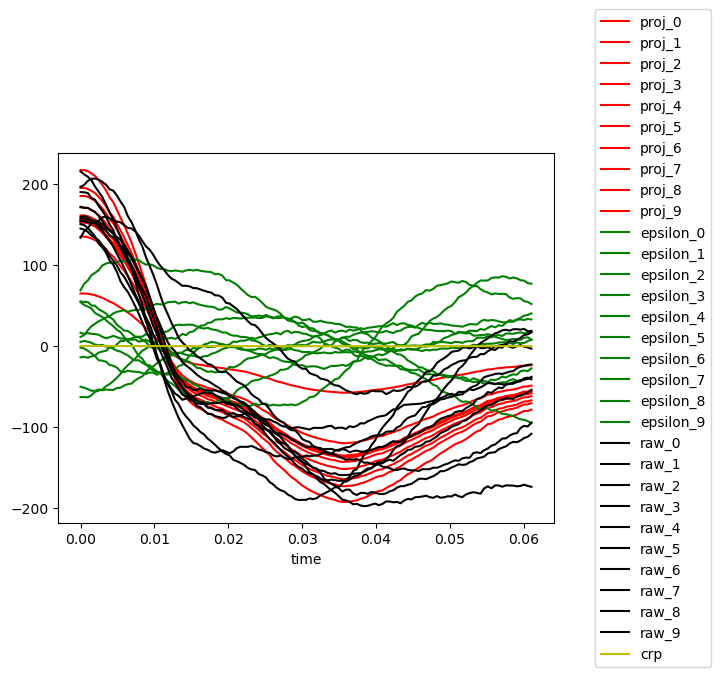

In [215]:
#plot in aggregation
my_colors = ['r']*10+['g']*10+['k']*10 +['y']
trial_reparam_df.plot(kind='line',x='time',  color=my_colors)
plt.legend( bbox_to_anchor=[1.2, 0.5], loc='center')

Text(0.5, 1.0, 'CRP vs average normalized response')

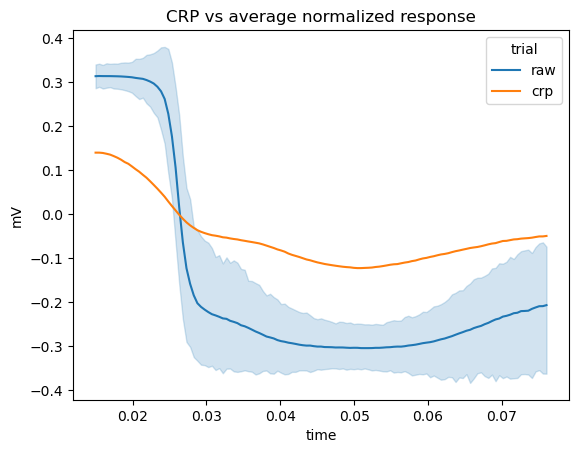

In [154]:
sns.lineplot(data=total_trial,x="time", y="mV", hue='trial')
plt.title("CRP vs average normalized response")

In [82]:
def lin_PCA(V):
    """returns the result of lin kernal PCA"""
    [S2,eigen_vectors] = np.linalg.eig(V.T@V,)
    S = np.sqrt(S2)
    sort_inds = np.argsort(S)[::-1]
    S = S[sort_inds]
    eigen_vectors = eigen_vectors[:,sort_inds]
    V_kernel = V@eigen_vectors
    return V_kernel / S[None,:]

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'a', 'b', 'c', 'd', 'e', 'f', 'g']

In [156]:
def construct_spes_df(spes_trains, contact_labels, fs):
    assert len(contact_labels) == min(spes_trains.shape)
    if np.argmax(spes_trains.shape) != 0:
        spes_trains = spes_trains.T
    nsamps,ch = spes_trains.shape
    t = np.arange(nsamps)/fs
    df = pd.DataFrame(columns=contact_labels, index =t, data=spes_trains)
    return  df

def get_stim(fname):
    fname = os.path.split(fname)[1]
    bipole = fname.split("_")[1] 
    return bipole.split("-")

def plot_reparam(reparam_df,k):
    assert "proj_0" in reparam_df.columns and 'epsilon_0' in reparam_df.columns, "Incorrect columns!"
    fig, axes = plt.subplots(nrows=k, ncols=1, sharex=True)
    for i in range(k):
        cols = [f'proj_{i}', f'epsilon_{i}', 'crp']
        ax = axes[i]
        df = flatten_df(reparam_df,cols,'type','time')
        sns.lineplot(data =df,y='voltage', x='time', hue='type', ax=ax)

def flatten_df(og_df, cols, flat_name, const_col):
    n,_ = og_df.shape
    flat_data = og_df[cols].values.flatten()
    flat_df = pd.DataFrame(data=flat_data,columns=['voltage'])
    flat_cols = []
    for c in cols:
        flat_cols = flat_cols + [c]*n
    flat_df[flat_name] = flat_cols
    #pdb.set_trace()
    flat_df[const_col] = np.tile(og_df[const_col],len(cols))
    return flat_df

def plot_channels(spes_df , channel_list):
    nrows = len(channel_list)
    fig, axes = plt.subplots(nrows=nrows, ncols=1,sharex=True)
    for i,ch in enumerate(channel_list):
        ax = axes[i]
        sns.lineplot(x=spes_df.index, y=spes_df[ch], ax=ax)
    
    